In [ ]:
!pip install livelossplot
!pip install tensorflow==2.1

     |████████████████████████████████| 421.8MB 23kB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
     |████████████████████████████████| 450kB 53.5MB/s 
     |████████████████████████████████| 3.9MB 44.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=a039ccc27de6853fae7270cc8fe69f25566cd068924b6cef54fc99afa1cb4d3a
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorflow-estimator 2.3.0
    Uninstalling tensorflow-estimator-2.3.0:
      Successfully uninstalled tensorflow-estimator-2.3.0
  Found existing installation: tensorboard 2.3.0
    Uninstalling tensorboard-2.3.0:
      Successfully uninsta

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
cd '/content/gdrive/My Drive/Colab Notebooks'

/content/gdrive/My Drive/Colab Notebooks


In [ ]:
cp 'ImageManipulationDataset.zip' '/content'

In [ ]:
cd '/content'

/content


In [ ]:
!unzip ImageManipulationDataset.zip

Archive:  ImageManipulationDataset.zip
   creating: Original/
  inflating: Original/Au_ani_0001.jpg  
  inflating: Original/Au_ani_0002.jpg  
  inflating: Original/Au_ani_0003.jpg  
  inflating: Original/Au_ani_0004.jpg  
  inflating: Original/Au_ani_0005.jpg  
  inflating: Original/Au_ani_0006.jpg  
  inflating: Original/Au_ani_0007.jpg  
  inflating: Original/Au_ani_0008.jpg  
  inflating: Original/Au_ani_0009.jpg  
  inflating: Original/Au_ani_0010.jpg  
  inflating: Original/Au_ani_0011.jpg  
  inflating: Original/Au_ani_0012.jpg  
  inflating: Original/Au_ani_0013.jpg  
  inflating: Original/Au_ani_0014.jpg  
  inflating: Original/Au_ani_0015.jpg  
  inflating: Original/Au_ani_0016.jpg  
  inflating: Original/Au_ani_0017.jpg  
  inflating: Original/Au_ani_0018.jpg  
  inflating: Original/Au_ani_0019.jpg  
  inflating: Original/Au_ani_0020.jpg  
  inflating: Original/Au_ani_0021.jpg  
  inflating: Original/Au_ani_0022.jpg  
  inflating: Original/Au_ani_0023.jpg  
  inflating: Origi

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

sns.set(style='white', context='notebook', palette='deep')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from PIL import Image
import os
from pylab import *
import re
from PIL import Image, ImageChops, ImageEnhance

In [ ]:
def get_imlist(path):
    return [os.path.join(path,f) for f in os.listdir(path) if f.endswith('.jpg') or f.endswith('.png')]

ELA Algorithm

In [ ]:
def convert_to_ela_image(path, quality):
    filename = path
    resaved_filename = 'tempresaved.jpg'
    ELA_filename = 'tempela.png'
    
    im = Image.open(filename).convert('RGB')
    im.save(resaved_filename, 'JPEG', quality = quality)
    resaved_im = Image.open(resaved_filename)
    
    ela_im = ImageChops.difference(im, resaved_im)
    
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    if max_diff == 0:
        max_diff = 1
    scale = 255.0 / max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)
    
    return ela_im

Real Image Sample

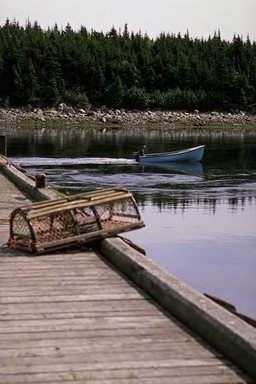

In [ ]:
Image.open('Original/Au_sec_0038.jpg')

ELA of Real Image

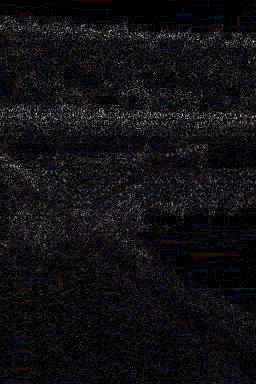

In [ ]:
convert_to_ela_image('Original/Au_sec_0038.jpg', 90)

Fake Image Sample

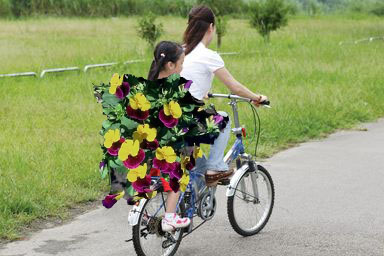

In [ ]:
Image.open('Spliced/Sp_D_CRN_A_cha0077_pla0022_0382.jpg')

ELA of Fake Image

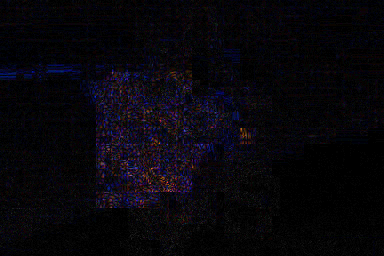

In [ ]:
convert_to_ela_image('Spliced/Sp_D_CRN_A_cha0077_pla0022_0382.jpg', 90)

Pre-processing the data to feed it to the network

In [ ]:
X = []
Y = []

In [ ]:
for i in os.listdir('Original'):
  X.append(array(convert_to_ela_image('Original/'+i, 90).resize((128, 128))).flatten() / 255.0)
  Y.append(0)

for i in os.listdir('Spliced'):
  X.append(array(convert_to_ela_image('Spliced/'+i, 90).resize((128, 128))).flatten() / 255.0)
  Y.append(1)

In [ ]:
X = np.array(X)
Y = np.array(Y)

In [ ]:
X = X.reshape(-1, 128, 128, 3)
Y = Y.reshape(-1)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [ ]:
print(len(X_train))
print(len(X_val))

1000
251


Defining CNN

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu', input_shape = (128,128,3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'valid', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(2, activation = "softmax"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 124, 124, 32)      2432      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 120, 120, 32)      25632     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 60, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 115200)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               29491456  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
model.compile(optimizer = Adam() , loss = "sparse_categorical_crossentropy", metrics=["accuracy"])

Defining the checkpoint to save the weights if the accuracy improves after each iteration

In [ ]:
checkpoint = ModelCheckpoint('FakeImgDetect.h5', monitor='loss', verbose=0,
    save_best_only=True, save_weights_only=True, mode='auto', save_freq='epoch')

Training

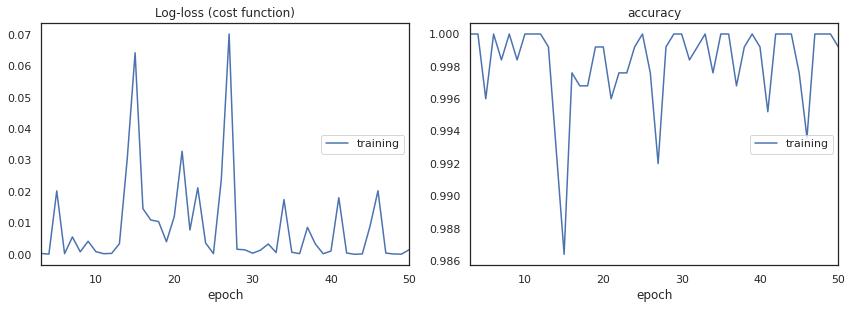

Log-loss (cost function):
training   (min:    0.000, max:    0.070, cur:    0.002)

accuracy:
training   (min:    0.986, max:    1.000, cur:    0.999)
1251/1251 - 3s - loss: 0.0016 - accuracy: 0.9992


In [ ]:
history = model.fit(X, Y, batch_size = 8, epochs = 50, verbose = 2, callbacks=[PlotLossesCallback(), checkpoint])    #validation_data = (X_val, Y_val)

In [ ]:
from google.colab import files
files.download('FakeImgDetect.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Testing

In [ ]:
test=array(convert_to_ela_image('Spliced/Sp_D_CRN_A_cha0077_pla0022_0382.jpg', 90).resize((128, 128))).flatten() / 255.0

In [ ]:
#test=array(convert_to_ela_image('Original/Au_sec_0038.jpg', 90).resize((128, 128))).flatten() / 255.0

In [ ]:
test=test.reshape(-1,128,128,3)

In [ ]:
result=model.predict(test)
print('Chances of being real : ',round(result[0][0],1))
print('Chances of being fake : ',round(result[0][1],1))

Chances of being real :  0.0
Chances of being fake :  1.0


Confusion matrix

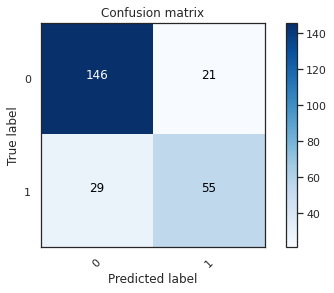

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
# Predict the values from the validation dataset
Y_pred = [0 if i[0]>i[1] else 1 for i in model.predict(X_val)]
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_val, Y_pred) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(2))